In [42]:
import re

import numpy as np
import pandas as pd
from numpy import sort
from scipy.cluster import hierarchy
from scipy.stats import spearmanr

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

import seaborn as sns
import shap
import statsmodels.api as sm

%matplotlib inline
%config InlineBackend.figure_format ='retina'
import statsmodels.stats.api as sms
import xgboost
from sklearn import datasets, metrics, model_selection, preprocessing
from sklearn.ensemble import (
    BaggingClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier,
)


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay

)
from sklearn.metrics import *
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    RepeatedKFold,
    cross_val_predict,
    cross_val_score,
    cross_validate,
    learning_curve,
    train_test_split,
    validation_curve,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from skopt.plots import plot_convergence

sns.set_style("darkgrid")
sns.mpl.rcParams["figure.figsize"] = (15.0, 9.0)

import warnings

import matplotlib
import matplotlib.pyplot as plt

warnings.simplefilter(action="ignore", category=FutureWarning)
from warnings import filterwarnings
warnings.filterwarnings('ignore')

filterwarnings("ignore")

seed = 0

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from keras.layers import LeakyReLU
from keras.optimizers import *
from keras.utils import np_utils
from keras import regularizers


In [43]:
data = pd.read_csv("training_cleaned.csv", header=0, sep=",")

In [44]:
data['BPlabel_encoded'] = data['BPlabel'].map( {'most likely':0,'probable':1, 'least likely':2})
Y = data["BPlabel_encoded"] 
data = data.drop(["BPlabel"],1)
data.shape 

(293, 22)

In [45]:
X = pd.read_csv("selected_features_training_data.csv", header=0)
X.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X.columns.values
]

X = MinMaxScaler().fit_transform(X)

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [47]:
def baseline_model(optimizer='RMSprop', learning_rate=0.01, momentum=0.3, activation='relu', dropout_rate=0.2, weight_constraint=0, neurons=200):
    model = Sequential()
    model.add(Dense(neurons, input_dim=6, activation=activation)) #dense layers perform: output = activation(dot(input, kernel) + bias).
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation=activation)) #8 is the dim/ the number of hidden units (units are the kernel)
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


keras = KerasClassifier(build_fn=baseline_model, batch_size=32, epochs=10, verbose=0)

In [48]:
history = keras.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs=100, batch_size=32)

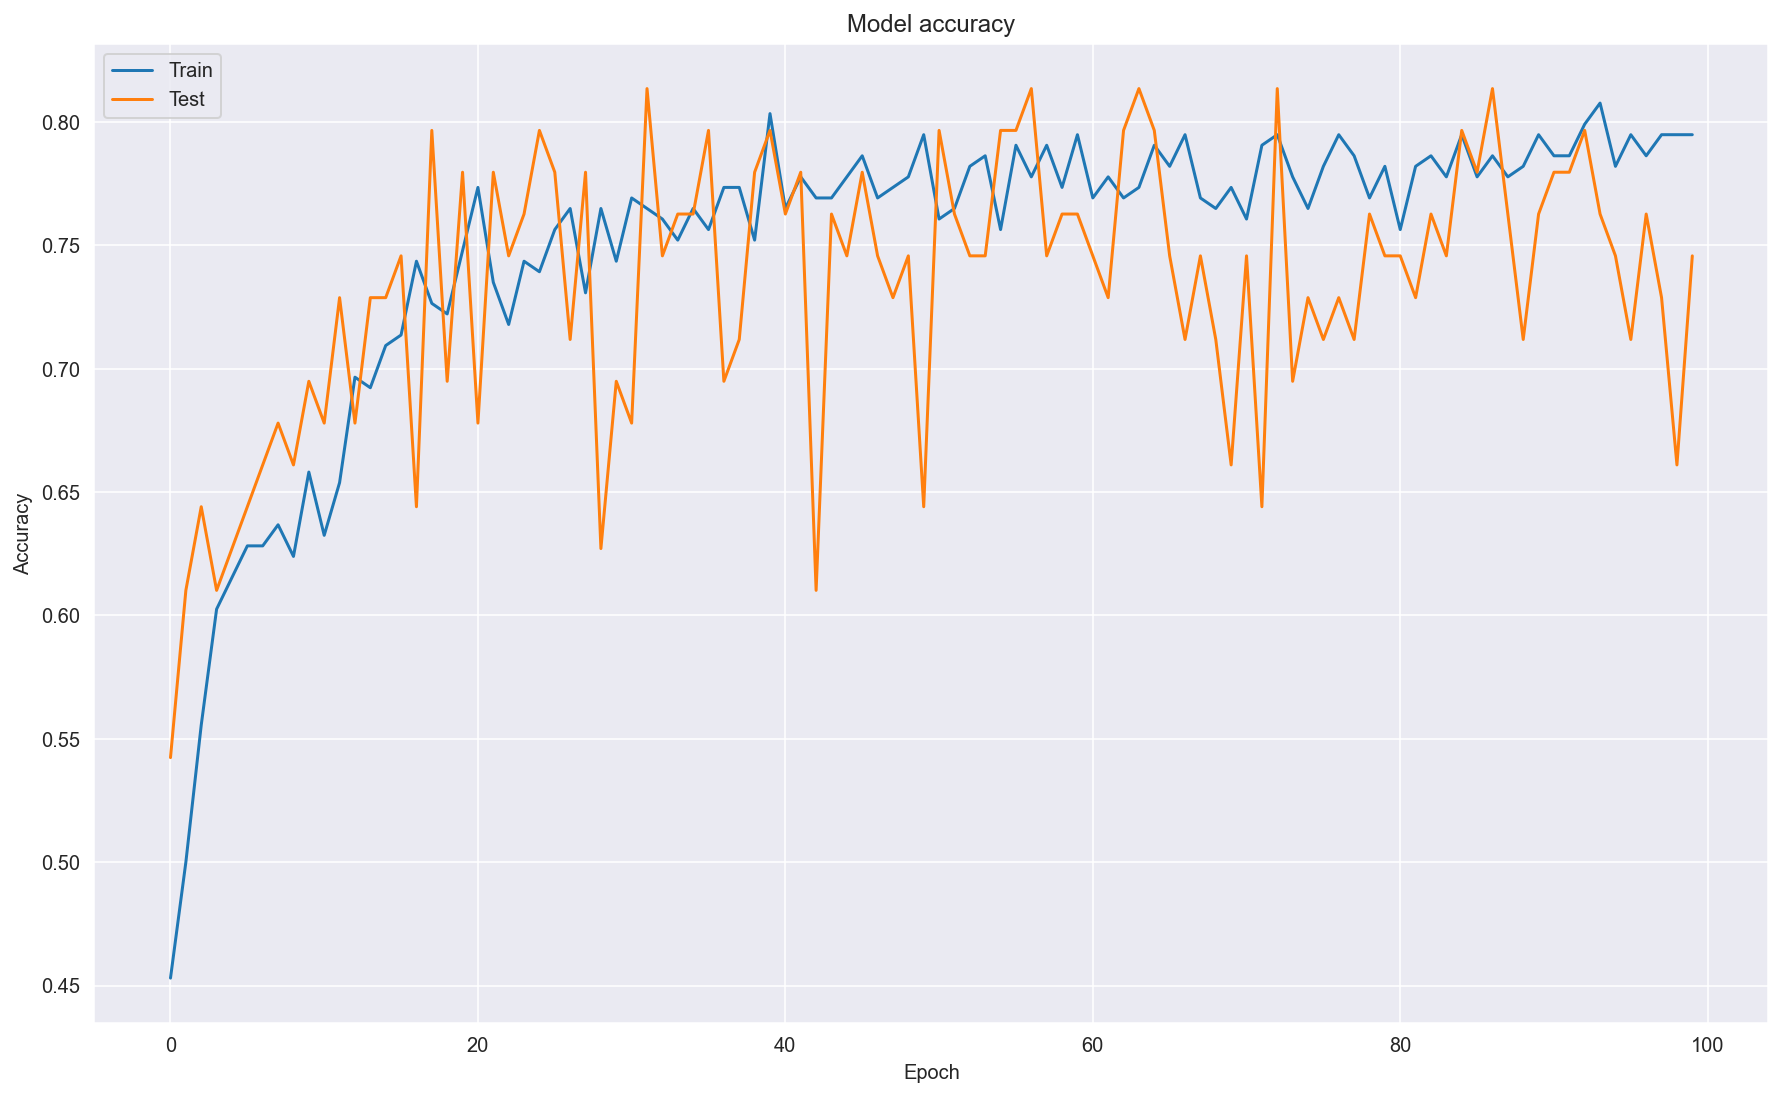

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

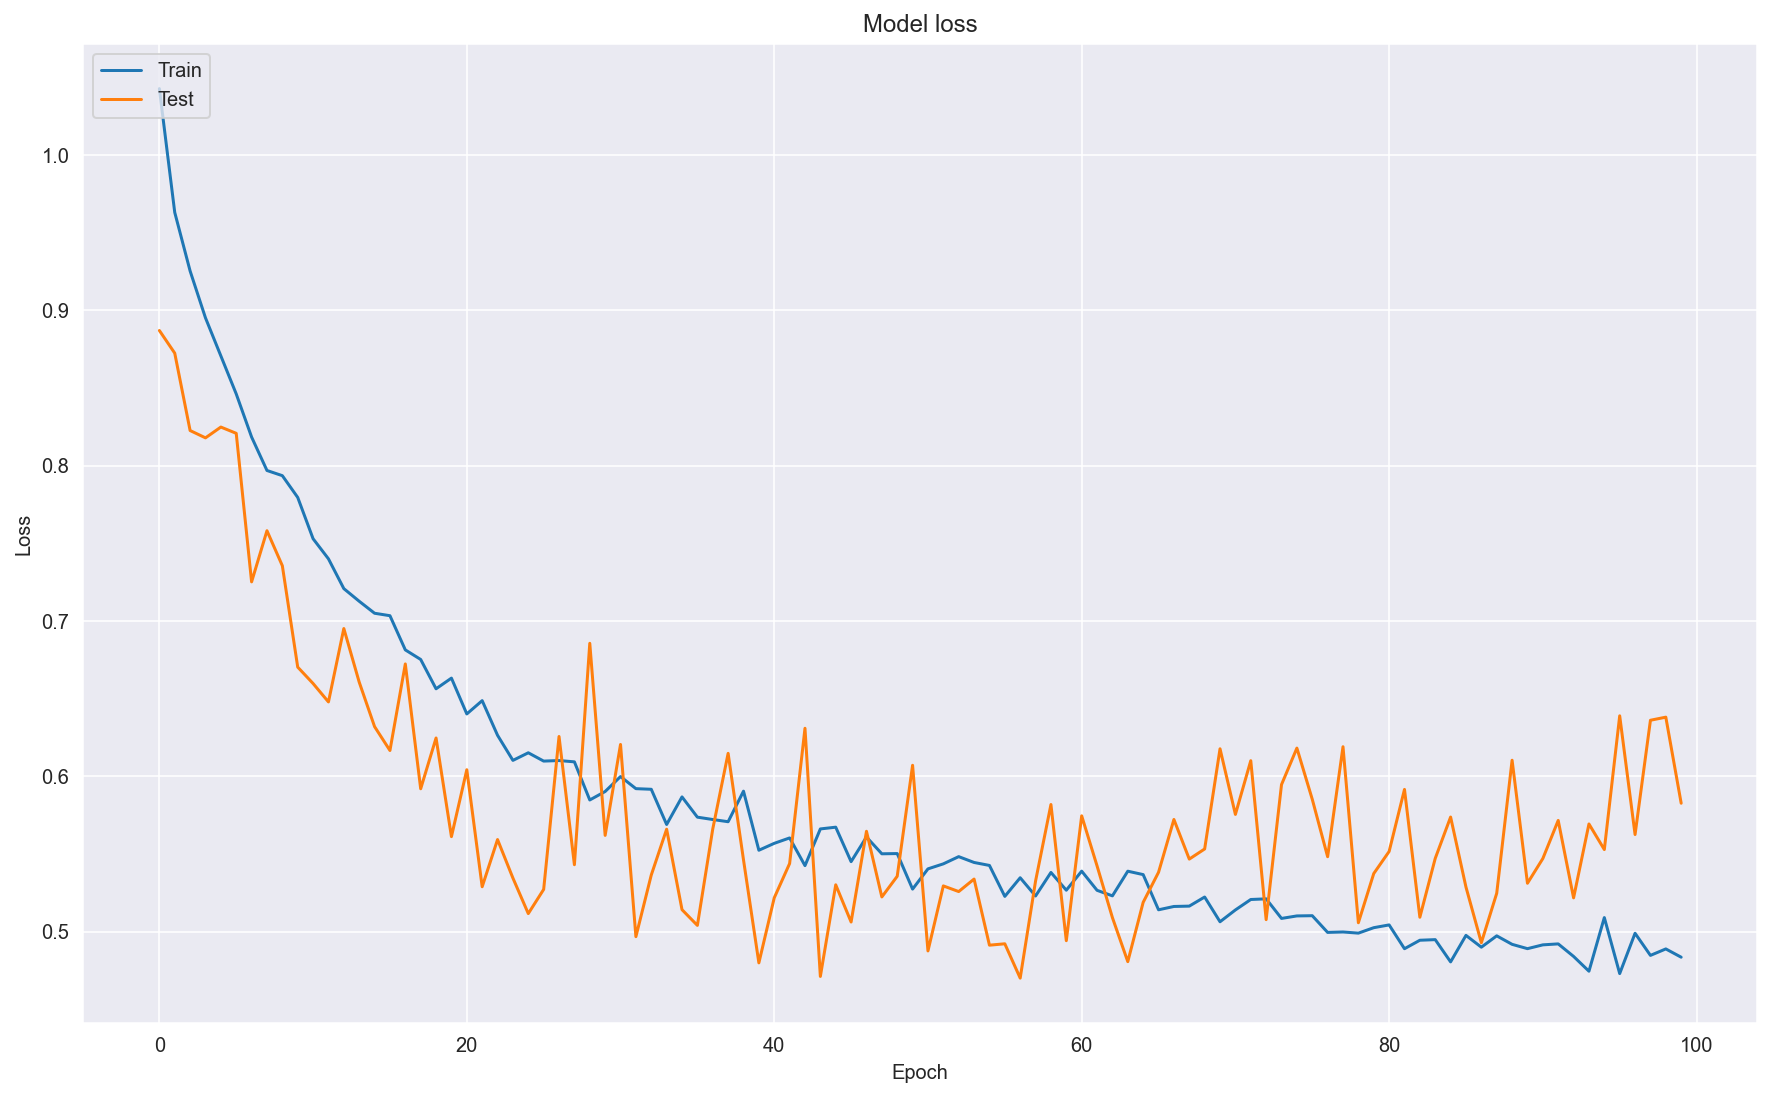

In [50]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [56]:
target_names = ['Most likely', 'Probable', 'Least likely']
keras.fit(X_train, Y_train)
predictions = list(keras.predict(X_test))
print(classification_report(Y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

 Most likely       0.25      0.14      0.18         7
    Probable       0.62      0.88      0.73        32
Least likely       0.80      0.40      0.53        20

    accuracy                           0.63        59
   macro avg       0.56      0.47      0.48        59
weighted avg       0.64      0.63      0.60        59



In [57]:
keras.fit(X, Y)
y_pred = list(keras.predict(X))
y_true=Y
cm = confusion_matrix(y_true, y_pred)

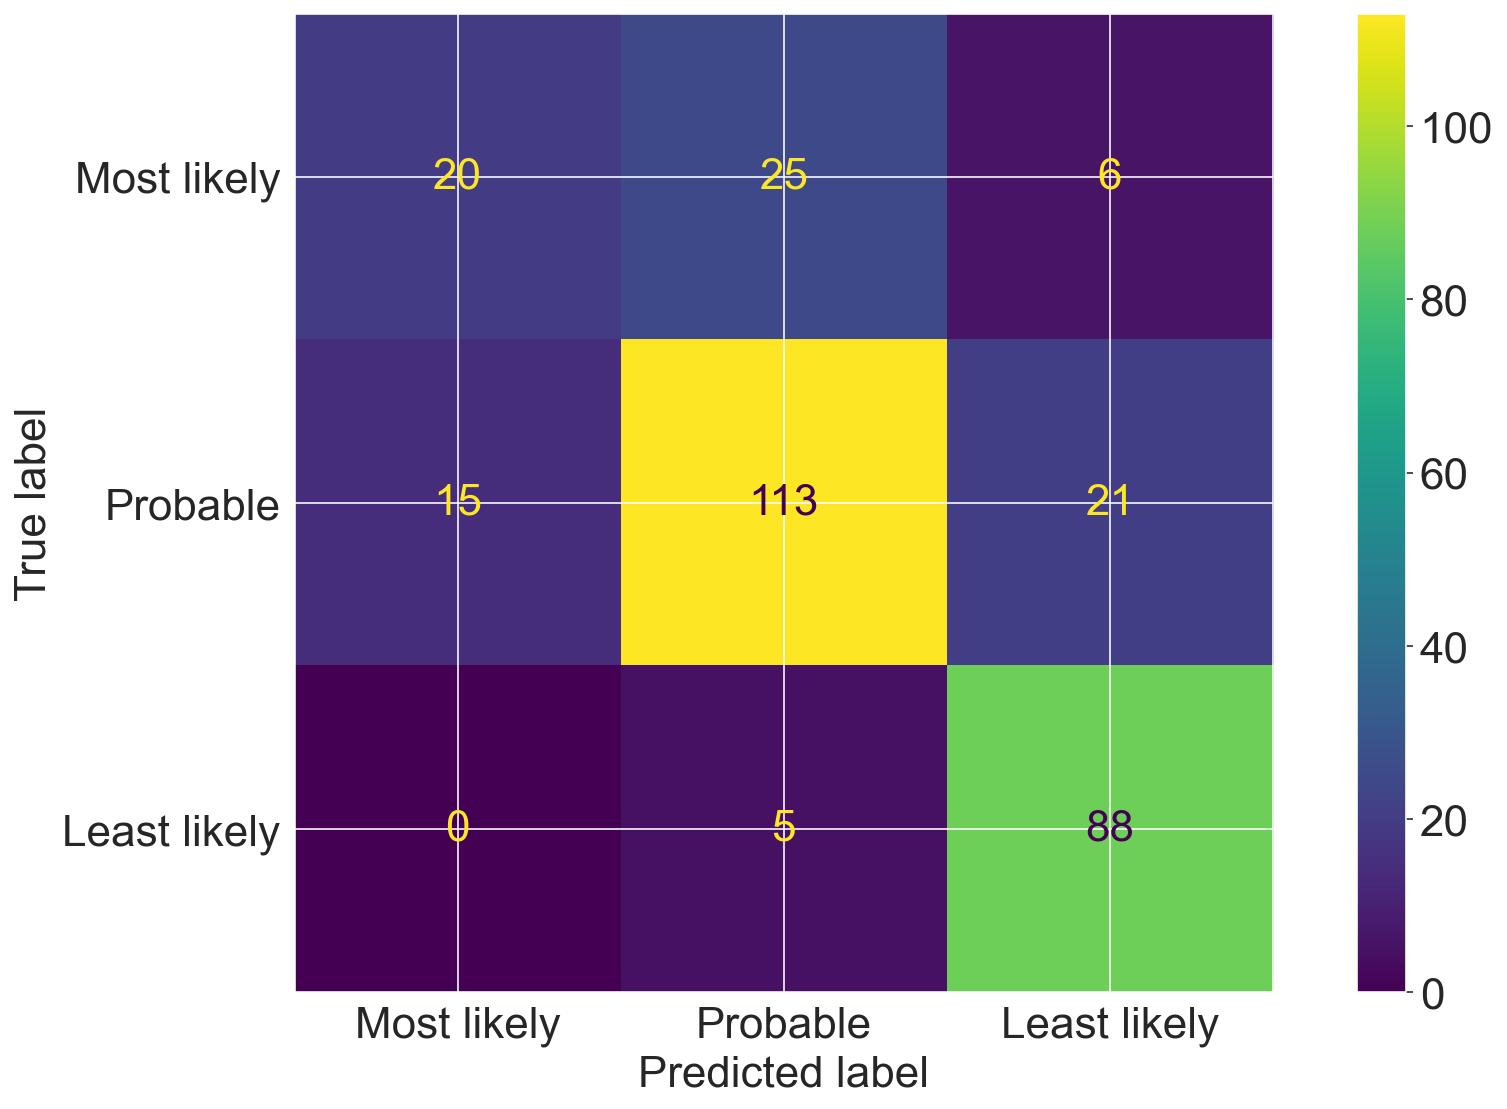

In [62]:
font = {'family' : 'Arial',
    'weight' : 'normal',
    'size'   : 22}
plt.rc('font', **font)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=target_names)
disp.plot()